In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# Train Validation Set Split

In [3]:
def train_valid_split(data, ratio=0.1, batchSize=4, shuffle = True):
    nSample = len(data)
    
    if shuffle:
        index = torch.randperm(nSample)
    else:
        index = torch.arange(0,nSample)
    
    nValid = int(nSample*ratio)
    
    validIndex, trainIndex = index[:nValid], index[nValid:]
    
    validSampler = torch.utils.data.sampler.SubsetRandomSampler(validIndex)
    
    trainSampler = torch.utils.data.sampler.SubsetRandomSampler(trainIndex)
    
    trainloader = torch.utils.data.DataLoader(data, batch_size=batchSize,
                                         sampler=trainSampler, num_workers=2)
    
    validloader = torch.utils.data.DataLoader(data, batch_size=batchSize,
                                         sampler=validSampler, num_workers=2)
    
    return trainloader, validloader, trainSampler

In [5]:
batchSize = 128
transformTrain = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(28),
     transforms.Scale(32),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
transformTest = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

trainset = torchvision.datasets.CIFAR10(root='./datasets/CIFAR-10', train=True,
                                        download=True, transform=transformTrain)

testset = torchvision.datasets.CIFAR10(root='./datasets/CIFAR-10', train=False,
                                       download=True, transform=transformTest)

testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         num_workers=2)

trainloader, validloader, trainSampler = train_valid_split(trainset, batchSize = batchSize)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


3. Accuracy 90.24%

$INPUT -> [[CONV -> RRELU -> BN] * 4 -> POOL] * 2 -> [FC -> RRELU] * 2 -> FC$

In [6]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding = 1)
        self.conv12_bn = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 64, 3, padding = 1)
        
        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
        self.conv34_bn = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 128, 3, padding = 1)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv5 = nn.Conv2d(128, 256, 3, padding = 1)
        self.conv56_bn = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(256, 256, 3, padding = 1)
        
        self.conv7 = nn.Conv2d(256, 512, 3, padding = 1)
        self.conv78_bn = nn.BatchNorm2d(512)
        
        self.conv8 = nn.Conv2d(512, 512, 3, padding = 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(512 * 8 * 8, 4096)
        nn.init.xavier_normal(self.fc1.weight)
        
        self.fc2 = nn.Linear(4096, 4096)
        nn.init.xavier_normal(self.fc2.weight)
        
        self.fc3 = nn.Linear(4096, 10)
        nn.init.xavier_normal(self.fc3.weight)

    def forward(self, x):
        x = self.conv12_bn(F.rrelu(self.conv1(x)))
        x = self.conv12_bn(F.rrelu(self.conv2(x)))
        x = self.conv34_bn(F.rrelu(self.conv3(x)))
        x = self.conv34_bn(self.pool1(F.rrelu(self.conv4(x))))
        
        x = self.conv56_bn(F.rrelu(self.conv5(x)))
        x = self.conv56_bn(F.rrelu(self.conv6(x)))
        x = self.conv78_bn(F.rrelu(self.conv7(x)))
        x = self.conv78_bn(self.pool2(F.rrelu(self.conv8(x))))
        
        x = x.view(-1, 512 * 8 * 8)
        x = F.rrelu(self.fc1(x))
        x = F.rrelu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().cuda()
print(net)

Net (
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv34_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv56_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv78_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d (

In [7]:
def Accuracy(dataloader):
    correct = 0
    total = 0
    for data in dataloader:
        images, labels = data
        outputs = net(Variable(images).cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()
    return 100.0 * correct / total

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(net.parameters(), lr=0.001)#, weight_decay = 0.001)
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay = 0.001)

maxIter = 100
trainAcc = torch.zeros(maxIter)
validAcc = torch.zeros(maxIter)
testAcc = torch.zeros(maxIter)

#earlyStopping = torch.zeros(3)
#bestPara = net.parameters()

for epoch in range(100):# loop over the dataset multiple times
    #trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
    #                                sampler=trainSampler, num_workers=2)
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
    print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / len(trainloader)))
    running_loss = 0.0
    trainAcc[epoch] = Accuracy(trainloader)
    print('Accuracy of the network on the 45000 train images: %5.2f %%' % (trainAcc[epoch]))

    validAcc[epoch] = Accuracy(validloader)
    print('Accuracy of the network on the 5000 valid images: %5.2f %%' % (validAcc[epoch]))

    testAcc[epoch] = Accuracy(testloader)
    print('Accuracy of the network on the 10000 test images: %5.2f %%' % (testAcc[epoch]))
    
    #earlyStopping[2] = earlyStopping[1]
    #earlyStopping[1] = earlyStopping[0]
    #earlyStopping[0] = validAcc[epoch]
    
    
    #if validAcc > earlyStopping[1]:
    #    bestPara = net.parameters()
    
    #if epoch > 15 and earlyStopping[0] < earlyStopping[1] < earlyStopping[2]:
    #    print('Statisfy the earlyStopping condition')
    #    break;
#net.parameters() = bestPara
print('Finished Training')

[1,   352] loss: 1.255
Accuracy of the network on the 45000 train images: 67.58 %
Accuracy of the network on the 5000 valid images: 66.44 %
Accuracy of the network on the 10000 test images: 68.30 %
[2,   352] loss: 0.812
Accuracy of the network on the 45000 train images: 74.90 %
Accuracy of the network on the 5000 valid images: 74.28 %
Accuracy of the network on the 10000 test images: 74.00 %
[3,   352] loss: 0.666
Accuracy of the network on the 45000 train images: 78.40 %
Accuracy of the network on the 5000 valid images: 75.44 %
Accuracy of the network on the 10000 test images: 76.71 %
[4,   352] loss: 0.587
Accuracy of the network on the 45000 train images: 81.04 %
Accuracy of the network on the 5000 valid images: 77.96 %
Accuracy of the network on the 10000 test images: 78.73 %
[5,   352] loss: 0.530
Accuracy of the network on the 45000 train images: 84.11 %
Accuracy of the network on the 5000 valid images: 80.52 %
Accuracy of the network on the 10000 test images: 81.58 %
[6,   352]

Accuracy of the network on the 5000 valid images: 88.82 %
Accuracy of the network on the 10000 test images: 88.26 %
[43,   352] loss: 0.087
Accuracy of the network on the 45000 train images: 97.39 %
Accuracy of the network on the 5000 valid images: 88.90 %
Accuracy of the network on the 10000 test images: 88.79 %
[44,   352] loss: 0.082
Accuracy of the network on the 45000 train images: 97.59 %
Accuracy of the network on the 5000 valid images: 88.58 %
Accuracy of the network on the 10000 test images: 88.66 %
[45,   352] loss: 0.080
Accuracy of the network on the 45000 train images: 97.48 %
Accuracy of the network on the 5000 valid images: 88.56 %
Accuracy of the network on the 10000 test images: 88.47 %
[46,   352] loss: 0.082
Accuracy of the network on the 45000 train images: 97.55 %
Accuracy of the network on the 5000 valid images: 88.56 %
Accuracy of the network on the 10000 test images: 88.54 %
[47,   352] loss: 0.078
Accuracy of the network on the 45000 train images: 97.85 %
Accur

Accuracy of the network on the 10000 test images: 89.83 %
[84,   352] loss: 0.057
Accuracy of the network on the 45000 train images: 98.43 %
Accuracy of the network on the 5000 valid images: 88.88 %
Accuracy of the network on the 10000 test images: 89.66 %
[85,   352] loss: 0.058
Accuracy of the network on the 45000 train images: 98.74 %
Accuracy of the network on the 5000 valid images: 90.02 %
Accuracy of the network on the 10000 test images: 89.65 %
[86,   352] loss: 0.054
Accuracy of the network on the 45000 train images: 98.40 %
Accuracy of the network on the 5000 valid images: 89.96 %
Accuracy of the network on the 10000 test images: 89.36 %
[87,   352] loss: 0.059
Accuracy of the network on the 45000 train images: 98.16 %
Accuracy of the network on the 5000 valid images: 89.30 %
Accuracy of the network on the 10000 test images: 89.79 %
[88,   352] loss: 0.057
Accuracy of the network on the 45000 train images: 98.35 %
Accuracy of the network on the 5000 valid images: 89.76 %
Accur

In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images).cuda())
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels.cuda()).squeeze()
    for i in range(len(labels)):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %5.2f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 90.00 %
Accuracy of   car : 95.60 %
Accuracy of  bird : 87.20 %
Accuracy of   cat : 78.60 %
Accuracy of  deer : 90.90 %
Accuracy of   dog : 83.60 %
Accuracy of  frog : 95.20 %
Accuracy of horse : 93.00 %
Accuracy of  ship : 94.70 %
Accuracy of truck : 93.60 %


Accuracy of the network on the 10000 test images: 90.24 %


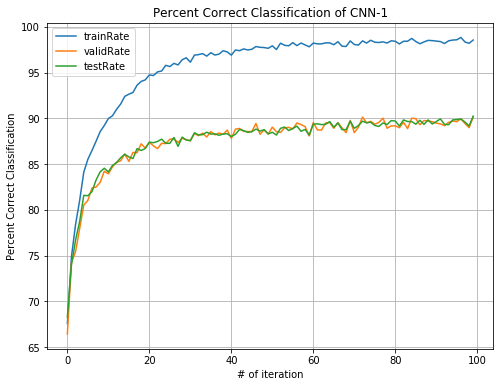

In [21]:
print('Accuracy of the network on the 10000 test images: %5.2f %%' % (testAcc.max()))
x = [i for i in range(epoch+1)]
plt.figure(figsize = (8,6))
trainRate, = plt.plot(x, trainAcc.numpy())
validRate, = plt.plot(x, validAcc.numpy())
testRate, = plt.plot(x, testAcc.numpy())
plt.legend([trainRate, validRate, testRate], ['trainRate', 'validRate', 'testRate'])
plt.xlabel('# of iteration')
plt.ylabel('Percent Correct Classification')
plt.title('Percent Correct Classification of CNN-1')
plt.grid()
plt.show()
